## Workflow to analyze Photometry data

### Imports

In [2]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

### Variables

In [105]:
import pandas as pd

trial_window = [-4000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

# if in non canonical, go upper in folder tree one additional level
basefolder, _ = os.path.split(os.getcwd())
basefolder, _ = os.path.split(basefolder)

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,r'params\tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'T:\Data\head-fixed\pyphotometry\data\cued_uncued_oct22'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [28]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Optional

Transfer Files from hierarchical folders by tasks to flat folders, for photometry and behaviour files

In [ ]:
# photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
# pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

# root_folders = [photo_root_dir, pycontrol_root_dir]
# horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
# horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

# copy_files_to_horizontal_folders(root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)

### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [116]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
pycontrol_files_path = r'T:\Data\head-fixed\pycontrol\cued_uncued_oct22'

# or this if you want to use data from the sample_data folder within the package
# pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
# pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

### Perform extraction of behavioural information by trial

In [125]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

cued_uncued_oct22 47 2022-10-10 15:56:38 188 47
cued_uncued_oct22 48 2022-10-10 15:56:38 50 30
cued_uncued_oct22 49 2022-10-10 17:04:08 19 8
cued_uncued_oct22 51 2022-10-10 17:04:08 32 35
cued_uncued_oct22 53 2022-10-10 17:07:54 47 47
No event  'reward_delay_timer'  found:  53 2022-10-11 10:19:42 cued_uncued_oct22
cued_uncued_oct22 53 2022-10-11 10:19:42 6 0
cued_uncued_oct22 47 2022-10-11 10:25:41 152 65
cued_uncued_oct22 53 2022-10-11 10:25:41 49 45
cued_uncued_oct22 48 2022-10-11 10:28:31 37 39
cued_uncued_oct22 49 2022-10-11 11:45:06 26 27
cued_uncued_oct22 51 2022-10-11 11:47:51 56 48
cued_uncued_oct22 47 2022-10-14 11:36:41 86 39
No event  'reward_delay_timer'  found:  48 2022-10-14 11:36:41 cued_uncued_oct22
cued_uncued_oct22 48 2022-10-14 11:36:41 5 4
cued_uncued_oct22 49 2022-10-14 11:40:28 21 49
cued_uncued_oct22 47 2022-10-17 10:12:41 61 37
No event  'reward_delay_timer'  found:  48 2022-10-17 10:12:41 cued_uncued_oct22
cued_uncued_oct22 48 2022-10-17 10:12:41 10 5
cued_uncu

### Match with photometry, videos, and DeepLabCut files

The following Warning : 

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads...

is due to rsync function for photometry-pycontrol alignment


In [118]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()


### Define conditions and groups for extraction

In [174]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'success': True, 'delayed reward spout cued': True, 'error_trial': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'success': False, 'delayed reward spout cued': True, 'error_trial': False, 'reward free': False, 'button_press': False}

conditions_dict3 = {'trigger': 'cued', 'valid': True, 'success': True, 'reward bar_off': True, 'button_press': False}
conditions_dict4 = {'trigger': 'cued', 'valid': True, 'success': False, 'reward bar_off': True, 'button_press': False}

conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'success': True, 'delayed reward spout uncued':True, 'error_trial': False, 'button_press': False}
conditions_dict6 = {'trigger': 'uncued', 'valid': True, 'success': False, 'delayed reward spout uncued':True, 'error_trial': False, 'button_press': False}

conditions_dict7 = {'trigger': 'uncued', 'valid': True, 'success': True, 'reward bar uncued':True, 'button_press': False}
conditions_dict8 = {'trigger': 'uncued', 'valid': True, 'success': False, 'reward bar uncued':True, 'button_press': False}

conditions_dict9 = {'trigger': 'cued', 'valid': True, 'error_trial': True, 'reward free': False, 'button_press': False}


# Aggregate all condition dictionaries in a list
condition_list = [
    conditions_dict1, 
    conditions_dict2, 
    conditions_dict3, 
    conditions_dict4,

    conditions_dict9,

    conditions_dict5, 
    conditions_dict6, 
    conditions_dict7, 
    conditions_dict8
    
    ]
    
# Aliases for conditions
cond_aliases = [
    'Cued delayed reward - hit',
    'Cued delayed reward - miss',

    'Cued reward bar release - hit', 
    'Cued reward bar release - miss', 

    'Cued - error', 
    
    'Uncued delayed reward - hit',
    'Uncued delayed reward - miss',

    'Uncued bar release - hit',
    'Uncued bar release - miss'

       
    ]
# Groups as a list of lists
# groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]


In [187]:
exp_cohort.sessions[11].df_conditions.head(10)

,trigger,success,valid,delayed reward spout cued,delayed reward spout uncued,error_trial,reward free_uncued,reward free,reward bar_off,reward bar uncued,button_press
trial_nb,,,,,,,,,,,
1,cued,True,False,False,False,False,False,False,True,False,False
2,cued,True,True,False,False,False,False,False,True,False,True
3,cued,True,True,False,False,False,False,False,True,False,False
4,cued,True,True,True,False,False,False,False,False,False,False
5,cued,True,True,False,False,True,False,False,False,False,False
6,cued,True,True,True,False,False,False,False,False,False,False
7,cued,True,True,True,False,False,False,False,False,False,False
8,cued,True,True,False,False,True,False,False,False,False,False
9,cued,False,True,False,False,False,False,False,False,False,False


Example in progress for Cued-Uncued

In [25]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True, 'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict3 = {'trigger': 'uncued', 'valid': True, 'reward free_uncued': True}
conditions_dict4 = {'trigger': 'uncued', 'valid': True, 'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'reward bar uncued': True, 'free_reward_timer': False, 'success': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Cued spout hit', 'Cued bar hit', 'Cued miss', \
    'Uncued miss', 'Uncued spout hit', 'Uncued bar hit']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]


Example in progress Pavlovian

In [28]:
# List of uncued conditions as listed on the tasks .csv file for task pavlovian_nobar_nodelay:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'success': True}
conditions_dict1 = {'success': False}


# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1]
# Aliases for conditions
cond_aliases = ['hit', 'miss']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Limit the Experiment group by only including a subset of sessions in a copied object

In [175]:
from copy import deepcopy
exp_cohort_subset = deepcopy(exp_cohort)

# Take only sessions where the task is 'reaching_go_nogo' and which have matching photometry files
exp_cohort_subset.sessions = [session for session in exp_cohort.sessions if (
    session.task_name == 'cued_uncued_oct22') 
    and (session.photometry_path is not None)
]#and (session.subject_ID == 296)]

exp_cohort_subset.by_trial = True

print(len(exp_cohort_subset.sessions))

11


### Extract Photometry trials and create a Continuous_Dataset

In [176]:
cont_dataset = exp_cohort_subset.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'cued_uncued_oct22', #'reaching_go_nogo',
        trig_on_ev = 'spout', # align to the first event of a kind e.g. bar_off
        high_pass = None, 
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        remove_artifacts = False, # To Deprecate in favor of Exp level artifact clustering
        verbose = False) # will plot all the process of remove_artifacts if remove_artifacts == True

cont_dataset.set_trial_window(trial_window, 'ms')


### Save Photometry Dataset

In [95]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'
cont_dataset.save(folder_path, 'photo_kms_reaching_go_nogo_mf3_lp45_spout')

Dataset saved in C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_kms_reaching_go_nogo_mf3_lp45_spout.pkl
data size is 26.977676391601562 Mb


### Reload a pre-existing dataset

In [96]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

ModuleNotFoundError: No module named 'trial_dataset_classes'

### Cluster trials to exclude artifacts

In [ ]:
cont_dataset.cluster_trials(
            vars_to_cluster_on = 'analog_2',  # only work with one var for now.
            dim_reduc_type = 'ICA',
            eps =  0.01,
            min_samples_by_cluster = 20, 
            plot = True,
            plot_lim_pctile = 0
            )
        

### Plot the different clusters of trials

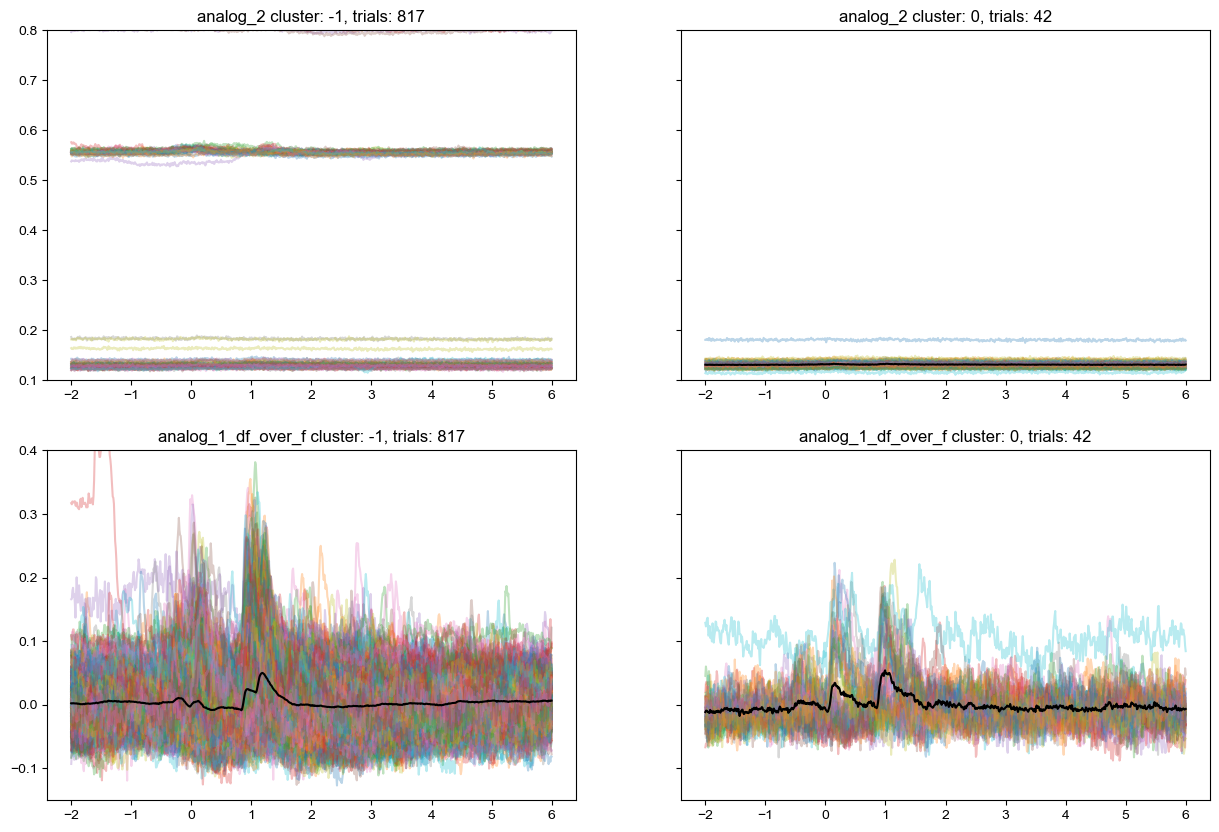

In [79]:
cont_dataset.plot_clustered_trials(
    vars_to_plot = ['analog_2','analog_1_df_over_f'],
    min_cluster_size_to_plot = 1,
    ylims = [[0.1,0.8],[-0.15,0.4]],
    figsize = (15,10)
    )

### Optional methods

In [185]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
# cont_dataset.filterout_conditions([1,3,4,5,6,7,8])
cont_dataset.filterout_conditions([1,3,7,8])

# exclude some groups by IDs
cont_dataset.filterout_groups([])

# exclude some subjects
cont_dataset.filterout_subjects([0,1, 48, 49,51, 53])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 7)

# Keep only last n sessions
cont_dataset.filter_lastNsessions(n = 3)

# Filter artifacted trials
# cont_dataset.filterout_clusters([-1, 1, 2]) # Good cluster is classically 0

# Exclude sessions by dates
# cont_dataset.filterout_dates(days_to_exclude = )

# To remove subjects who do not have
# trials in all the conditions
# Careful when using on sessions when not all conditions are present, 
# it could exclude a big number of whole sessions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

cond_ID: 0, group_idx 0, subj 47
cond_ID: 2, group_idx 0, subj 47
cond_ID: 4, group_idx 0, subj 47
cond_ID: 5, group_idx 0, subj 47


False    567
True     323
Name: keep, dtype: int64

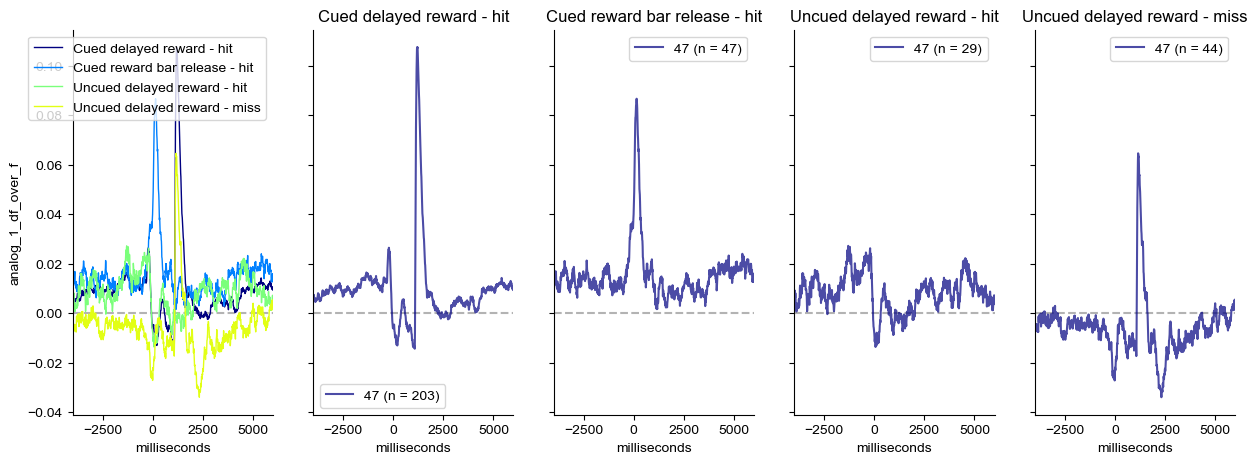

In [186]:
# if this was not set at creation
cont_dataset.set_trial_window([-4, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-4000, 6000],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (15, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



In [87]:
cont_dataset.get_groups()

array([array([280, 282, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300,
              301, 303, 304, 305, 306, 307], dtype=int64)                     ],
      dtype=object)

### Optional methods

In [178]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


AttributeError: 'Continuous_Dataset' object has no attribute 'filter_conditions'

 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


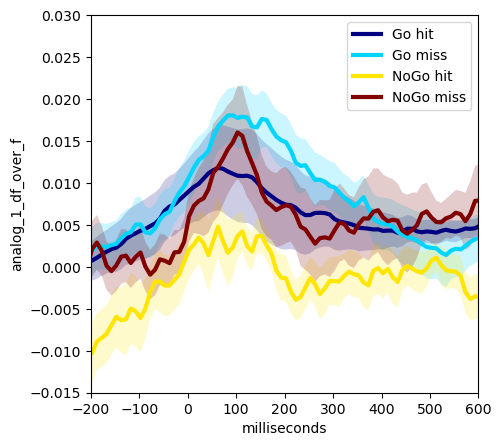

In [304]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)


In [305]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [306]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


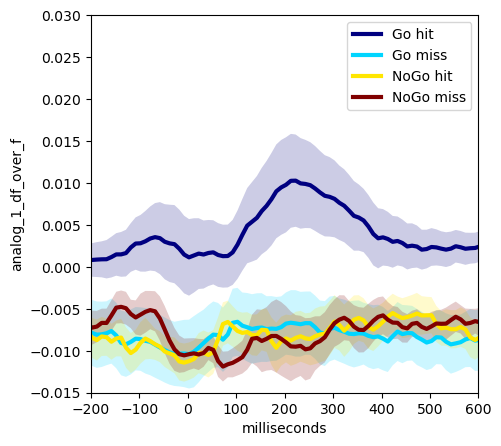

In [307]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)
